In [26]:
# Common Libraries
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
import re
import json
import glob
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
# allows us to import from the custom configs directory w/o affecting deepdisc library imports
sys.path.insert(0, '/u/yse2/deepdisc/configs')
print(sys.path)
# Astropy imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import make_lupton_rgb
from typing import List, NamedTuple
from multiprocessing import Pool
from itertools import chain

# Matplotlib and other libraries
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tqdm import tqdm

['/u/yse2/deepdisc/configs', '/u/yse2/deepdisc/configs', '/u/yse2/deepdisc/configs', '/projects/bdsp/miniconda3/envs/deepdiscnv/lib/python39.zip', '/projects/bdsp/miniconda3/envs/deepdiscnv/lib/python3.9', '/projects/bdsp/miniconda3/envs/deepdiscnv/lib/python3.9/lib-dynload', '', '/u/yse2/.local/lib/python3.9/site-packages', '/u/yse2/deepdisc/src', '/projects/bdsp/miniconda3/envs/deepdiscnv/lib/python3.9/site-packages', '/u/yse2/.local/lib/python3.9/site-packages/setuptools/_vendor']


In [15]:
root_dir = os.path.expanduser('~/lsst_data/')
folder = 'annotations_lvl5'
run_name = 'lsst5_30k_4h200_bs192_ep50'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_data = pd.read_json(test_data_fn)
print(f"Loaded test data from {test_data_fn} with {len(test_data)} entries.")

Loaded test data from /u/yse2/lsst_data/annotations_lvl5/test_8k.json with 8571 entries.


# Getting LSST Detection Catalog Info of Area Covered by Test Set

In [17]:
det_cat_paths = test_data.det_cat_path.tolist()
print(f"Found {len(det_cat_paths)} detection catalog files in test set which should match the {len(test_data)} images in test set.")

Found 8571 detection catalog files in test set which should match the 8571 images in test set.


In [18]:
def read_json(path):
    return pd.read_json(path)
cpu_count = len(os.sched_getaffinity(0))
with Pool(processes=cpu_count) as pool:
    all_det_cats = pool.map(read_json, det_cat_paths)

In [97]:
print(f"Loaded {len(all_det_cats)} detection catalogs which should again match the {len(test_data)} images in test set.")
print("The total number of detected objects by the LSST pipeline across the same area as the test set is (including potential duplicates):", sum([len(cat) for cat in all_det_cats]))
all_det_cats[0]

Loaded 8571 detection catalogs which should again match the 8571 images in test set.
The total number of detected objects by the LSST pipeline across the same area as the test set is (including potential duplicates): 271146


,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,mag_r_cModel,good,mag_i_cModel,psf_fwhm_u,dec,blendedness,y,parentObjectId,psf_fwhm_z,snr_u_cModel,snr_z_cModel,mag_y_cModel,objectId,snr_r_cModel,psf_fwhm_i,x,mag_g_cModel,mag_z,mag_r,tract,mag_u_cModel,psf_fwhm_g,snr_g_cModel,psf_fwhm_y,ra,mag_i,cutout_x,cutout_y
0,True,26.054455,0.839360,"6,2",26.391528,1.372450,7.986091,0,25.115672,26.035569,26.685812,True,25.708359,0.925686,-41.222714,0.000000,8301.694152,0,0.847045,4.179386,4.560655,25.650505,14329668756833311,6.237539,0.868881,25067.345009,26.388012,25.141164,26.635976,3258,26.065832,0.906069,8.217093,1.196548,53.668989,25.714607,17.345009,13.694152
1,True,26.667179,0.836192,"6,2",28.294721,0.410546,5.409555,1,26.385419,31.735020,27.075099,True,25.892972,0.943472,-41.221183,NaN,8329.108337,0,0.846885,0.030754,1.154764,26.817715,14329668756833388,3.546176,0.867337,25082.921703,27.971074,26.993767,27.463185,3258,31.225104,0.897965,1.592505,1.195475,53.667857,26.146065,32.921703,41.108337
2,True,23.936885,0.833364,"6,2",26.123854,6.848957,30.585702,1,23.963736,26.357919,25.140088,True,24.149873,0.924146,-41.220568,0.000000,8339.863405,0,0.849014,3.377634,11.753589,23.854481,14329668756833406,23.359300,0.867901,25117.101120,26.006479,24.087959,25.257772,3258,26.248074,0.906053,10.749887,1.196572,53.665341,24.252631,67.101120,51.863405
3,True,23.860131,0.833865,"6,2",25.951169,8.531146,15.419505,1,23.792243,25.744292,25.128124,True,24.548593,0.926936,-41.220301,0.000000,8344.889773,0,0.849001,6.038030,8.587440,23.384706,14329668756833419,16.907972,0.867221,25093.344833,25.346523,24.446765,25.765215,3258,25.124282,0.906057,14.465168,1.196555,53.667098,25.096791,43.344833,56.889773
4,True,NaN,0.836197,"6,2",25.781982,-0.727757,6.410049,1,26.214673,26.471734,25.731325,True,25.636995,0.926919,-41.220498,0.000000,8341.655391,0,0.846870,2.907301,1.068726,NaN,14329668756833425,11.110027,0.868809,25060.137120,25.441619,26.205720,26.108692,3258,26.072404,0.906063,15.084706,1.195475,53.669548,26.019545,10.137120,53.655391
5,True,24.840218,0.836202,"6,2",26.099701,2.856095,5.553817,1,25.221534,25.705855,25.710996,True,26.051119,0.926921,-41.219474,0.000000,8359.981043,0,0.848991,6.129022,3.934252,24.807957,14329668756833476,13.713522,0.869373,25071.847099,26.059700,25.306968,25.815141,3258,25.580912,0.907684,10.543681,1.200363,53.668696,26.097443,21.847099,71.981043
6,True,30.060454,0.833913,"6,2",27.394013,0.151340,5.135366,1,25.835418,27.570676,26.954821,True,26.190622,0.943472,-41.218027,0.000000,8385.198389,0,0.848959,0.948133,2.308857,28.015654,14329668756833536,4.905193,0.867918,25160.296835,27.383488,25.842960,26.980564,3258,27.717676,0.903629,3.285010,1.198778,53.662182,26.209502,110.296835,97.198389
7,True,23.592063,0.832814,"6,2",25.092457,8.933906,18.849922,1,24.209831,24.880459,24.692170,True,24.455258,0.935469,-41.217213,0.000000,8400.004900,0,0.848951,12.625883,8.388419,23.354426,14329668756833577,28.493638,0.865447,25143.115455,24.730802,24.498918,25.095767,3258,24.538204,0.905219,27.231618,1.201821,53.663461,24.810187,93.115455,112.004900
8,True,24.866958,0.834110,"6,2",26.783784,2.634095,6.602603,1,24.861297,NaN,25.883225,True,25.940450,0.943472,-41.215391,0.000000,8433.465483,0,0.847958,-1.516852,5.576844,24.904561,14329668756833654,13.003197,0.863851,25072.633576,26.809588,24.861897,25.909474,3258,NaN,0.900295,5.535992,1.200819,53.668689,25.899644,22.633576,145.465483
9,True,24.735922,0.836932,"6,2",26.309538,3.241447,2.948095,1,25.832252,27.076043,25.825675,True,26.583974,0.921591,-41.220270,0.000000,8344.865275,0,0.848950,1.721062,1.882420,24.574742,14329668756843164,10.999751,0.867366,25154.564249,26.085179,26.025964,26.107074,3258,26.849469,0.906045,8.963030,1.196049,53.662578,26.745646,104.564249,56.865275


Since we have $>200k$ objects across 8571 detection catalogs, we need a fast way to combine all of these objects into one big dataframe. Using `pd.concat()` for a large number of dataframes is really slow because it repeatedly copies DataFrame indices and builds the result incrementally. Instead, we use `itertools.chain.from_iterable()` to efficiently flatten each column across all data, then construct a single DataFrame from the resulting dictionary. This way is much faster and more memory-efficient.

In [32]:
col_names = all_det_cats[0].columns.tolist()
col_names

['clean',
 'mag_y',
 'psf_fwhm_r',
 'patch',
 'mag_g',
 'snr_y_cModel',
 'snr_i_cModel',
 'extendedness',
 'mag_z_cModel',
 'mag_u',
 'mag_r_cModel',
 'good',
 'mag_i_cModel',
 'psf_fwhm_u',
 'dec',
 'blendedness',
 'y',
 'parentObjectId',
 'psf_fwhm_z',
 'snr_u_cModel',
 'snr_z_cModel',
 'mag_y_cModel',
 'objectId',
 'snr_r_cModel',
 'psf_fwhm_i',
 'x',
 'mag_g_cModel',
 'mag_z',
 'mag_r',
 'tract',
 'mag_u_cModel',
 'psf_fwhm_g',
 'snr_g_cModel',
 'psf_fwhm_y',
 'ra',
 'mag_i',
 'cutout_x',
 'cutout_y']

In [27]:
# build dict col-by-col
df_dict = {}
for col in col_names:
    df_dict[col] = list(chain.from_iterable(df[col] for df in all_det_cats))
full_det_cat = pd.DataFrame(df_dict)
# We're able to form the full detection catalog df in ~17.5s

In [95]:
full_det_cat

,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,mag_r_cModel,good,mag_i_cModel,psf_fwhm_u,dec,blendedness,y,parentObjectId,psf_fwhm_z,snr_u_cModel,snr_z_cModel,mag_y_cModel,objectId,snr_r_cModel,psf_fwhm_i,x,mag_g_cModel,mag_z,mag_r,tract,mag_u_cModel,psf_fwhm_g,snr_g_cModel,psf_fwhm_y,ra,mag_i,cutout_x,cutout_y
0,True,26.054455,0.839360,"6,2",26.391528,1.372450,7.986091,0.0,25.115672,26.035569,26.685812,True,25.708359,0.925686,-41.222714,0.000000,8301.694152,0,0.847045,4.179386,4.560655,25.650505,14329668756833311,6.237539,0.868881,25067.345009,26.388012,25.141164,26.635976,3258,26.065832,0.906069,8.217093,1.196548,53.668989,25.714607,17.345009,13.694152
1,True,26.667179,0.836192,"6,2",28.294721,0.410546,5.409555,1.0,26.385419,31.735020,27.075099,True,25.892972,0.943472,-41.221183,NaN,8329.108337,0,0.846885,0.030754,1.154764,26.817715,14329668756833388,3.546176,0.867337,25082.921703,27.971074,26.993767,27.463185,3258,31.225104,0.897965,1.592505,1.195475,53.667857,26.146065,32.921703,41.108337
2,True,23.936885,0.833364,"6,2",26.123854,6.848957,30.585702,1.0,23.963736,26.357919,25.140088,True,24.149873,0.924146,-41.220568,0.000000,8339.863405,0,0.849014,3.377634,11.753589,23.854481,14329668756833406,23.359300,0.867901,25117.101120,26.006479,24.087959,25.257772,3258,26.248074,0.906053,10.749887,1.196572,53.665341,24.252631,67.101120,51.863405
3,True,23.860131,0.833865,"6,2",25.951169,8.531146,15.419505,1.0,23.792243,25.744292,25.128124,True,24.548593,0.926936,-41.220301,0.000000,8344.889773,0,0.849001,6.038030,8.587440,23.384706,14329668756833419,16.907972,0.867221,25093.344833,25.346523,24.446765,25.765215,3258,25.124282,0.906057,14.465168,1.196555,53.667098,25.096791,43.344833,56.889773
4,True,NaN,0.836197,"6,2",25.781982,-0.727757,6.410049,1.0,26.214673,26.471734,25.731325,True,25.636995,0.926919,-41.220498,0.000000,8341.655391,0,0.846870,2.907301,1.068726,NaN,14329668756833425,11.110027,0.868809,25060.137120,25.441619,26.205720,26.108692,3258,26.072404,0.906063,15.084706,1.195475,53.669548,26.019545,10.137120,53.655391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271141,True,26.132345,0.837439,"3,4",26.312939,0.948628,3.461150,1.0,27.125819,26.967916,26.408851,True,26.611819,0.936157,-39.275169,0.011228,16632.612650,15138505587951461,0.893929,1.902155,0.773588,26.133821,15138505587978823,7.871330,0.854956,14555.732485,26.288937,27.171961,26.456067,3442,26.986949,0.898018,9.449028,1.154099,51.388617,26.588257,99.732485,120.612650
271142,True,24.768463,0.839339,"3,4",25.539306,3.527315,11.364457,1.0,25.243289,25.266529,25.504555,True,25.314578,0.943115,-39.274868,0.021014,16638.068411,15138505587951498,0.890599,8.907516,4.303372,24.704077,15138505587978876,18.301364,0.852467,14483.236805,25.509292,25.237732,25.536465,3442,25.255952,0.911635,18.806127,1.154135,51.393820,25.338946,27.236805,126.068411
271143,True,30.346829,0.839340,"3,4",26.752295,NaN,4.967199,1.0,NaN,26.895290,26.910515,True,26.125479,0.943108,-39.274448,0.150871,16645.631957,15138505587951498,0.898320,2.090186,NaN,NaN,15138505587978877,4.613379,0.852469,14486.909927,26.538491,31.173504,27.009309,3442,26.771803,0.911641,6.316508,1.157728,51.393556,26.246633,30.909927,133.631957
271144,True,NaN,0.839339,"3,4",26.888039,NaN,3.755131,1.0,25.989924,NaN,26.502842,True,26.459552,0.931127,-39.274803,0.061293,16639.239282,15138505587951498,0.890600,NaN,1.896741,NaN,15138505587978878,6.380898,0.852465,14491.168190,26.703551,26.177380,26.689888,3442,NaN,0.911639,5.585058,1.157728,51.393251,26.532202,35.168190,127.239282


In [100]:
print(len(np.unique(full_det_cat.objectId.values)), "unique objects in detection catalog that covers the same cutout areas as the test set.")

271146 unique objects in detection catalog that covers the same cutout areas as test set.


In [101]:
det_cat_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_det_cat.json'
if not full_det_cat.empty:
    full_det_cat.to_json(det_cat_fn, orient='records')
    print(f"Saved det catalog of {len(full_det_cat)} objects that span the same cutouts of the test set to {det_cat_fn}")

Saved det catalog of 271146 objects that span the same cutouts of the test set to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_det_cat.json


# Getting Truth Information of All Objects in Test Set

In [105]:
def get_truth_test_cat(test_data):
    """
    Gets object information for the ground truth annotations from the test data

    Args:
        test_data (list): A list of dictionaries, where each dictionary contains
            image information and annotations
    Returns:
        truth_cat (dict): dict w/ keys containing info of gt_objs
    """
    ras  = [ann['ra'] for sublist in test_data.annotations for ann in sublist]
    decs = [ann['dec'] for sublist in test_data.annotations for ann in sublist]
    classes = [ann['category_id'] for sublist in test_data.annotations for ann in sublist]
    obj_ids = [ann['obj_id'] for sublist in test_data.annotations for ann in sublist]
    obj_truth_idxs = [ann['obj_truth_idx'] for sublist in test_data.annotations for ann in sublist]
    mags = [ann['mag_i'] for sublist in test_data.annotations for ann in sublist]
    # turn them into dicts
    truth_cat = {'ra': np.hstack(ras), 'dec': np.hstack(decs), 'mag_i': np.hstack(mags),
                'class': np.hstack(classes), 'obj_id': np.hstack(obj_ids), 'obj_truth_idx': np.hstack(obj_truth_idxs)}
    return truth_cat

In [106]:
truth_cat = get_truth_test_cat(test_data)
truth_cat_df = pd.DataFrame(truth_cat)
truth_cat_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_truth_cat.json'
if not truth_cat_df.empty:
    truth_cat_df.to_json(truth_cat_fn, orient='records')
    print(f"Saved truth catalog of {len(truth_cat_df)} objects in our test set to {truth_cat_fn}")

truth_cat_df

Saved truth catalog of 254756 objects in our test set to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_truth_cat.json


,ra,dec,mag_i,class,obj_id,obj_truth_idx
0,53.663637,-41.215570,26.462698,0,9502312400,8
1,53.666375,-41.218364,26.182444,0,9501803150,9
2,53.666449,-41.216024,23.855207,0,9502520267,13
3,53.666394,-41.215661,24.306143,0,9502520268,14
4,53.668981,-41.222707,25.905224,0,9502137039,18
...,...,...,...,...,...,...
254751,51.393470,-39.274480,26.819012,0,8641057299,129
254752,51.388997,-39.281391,25.149429,0,8641061146,130
254753,51.387510,-39.279938,26.572065,0,8641062913,131
254754,51.388541,-39.281171,25.909340,0,8641062914,132


Before we continue, we employ a magnitude cut on the truth catalog based on Rubin's nominal 5sigma depth adjusted for our 5-year coadds.

In [107]:
# same for all SNR levels
def truth_catalog_cut(baseline_mag_5sigma_10yr, years, baseline_snr=5, target_snr=5):
    """
    Calculate truth catalog magnitude cut at Rubin's nominal 5sigma depth adjusted 
    for the specified number of observation years.
    
    This cut is intended to be used consistently for defining the faint 
    limit of the truth sample for analysis (e.g., completeness), 
    including FOF matching.
    
    Parameters:
    baseline_mag_5sigma_10yr (float): 10-year 5σ depth (e.g., 26.8 for i-band)
    years (float): Analysis time baseline in years
    
    Returns:
    float: Magnitude cut for truth catalog
    """
    time_factor = np.sqrt(10 / years) # represents (sqrt(N_obs_10yr) / sqrt(N_obs_years))
    # delta_mag = 2.5 * log10(SNR_ratio)
    # SNR_ratio corresponds to 1 / time_factor for reaching the *same* SNR
    m_cut = baseline_mag_5sigma_10yr - 2.5 * np.log10(time_factor)
    # adjust for change in SNR threshold
    snr_ratio = baseline_snr / target_snr
    final_mcut = m_cut + 2.5 * np.log10(snr_ratio)
    return final_mcut

# for all SNR levels
baseline_mag_5sigma_10yr_i = 26.8  # From Rubin key numbers
years = 5
truth_mag_limit = truth_catalog_cut(baseline_mag_5sigma_10yr_i, years)
print(f"Truth catalog cut: mag_i <= {truth_mag_limit}")  # 26.42

Truth catalog cut: mag_i <= 26.423712505420024


In [108]:
mag_lim_truth_cat = truth_cat_df[truth_cat_df['mag_i'] <= truth_mag_limit]
mag_lim_truth_cat

,ra,dec,mag_i,class,obj_id,obj_truth_idx
1,53.666375,-41.218364,26.182444,0,9501803150,9
2,53.666449,-41.216024,23.855207,0,9502520267,13
3,53.666394,-41.215661,24.306143,0,9502520268,14
4,53.668981,-41.222707,25.905224,0,9502137039,18
5,53.667297,-41.216503,24.676319,0,9502183784,19
...,...,...,...,...,...,...
254747,51.388239,-39.275942,25.373577,0,8638094615,110
254748,51.388639,-39.275176,26.393204,0,8638094616,111
254750,51.390012,-39.279342,25.474951,0,8638642865,121
254752,51.388997,-39.281391,25.149429,0,8641061146,130


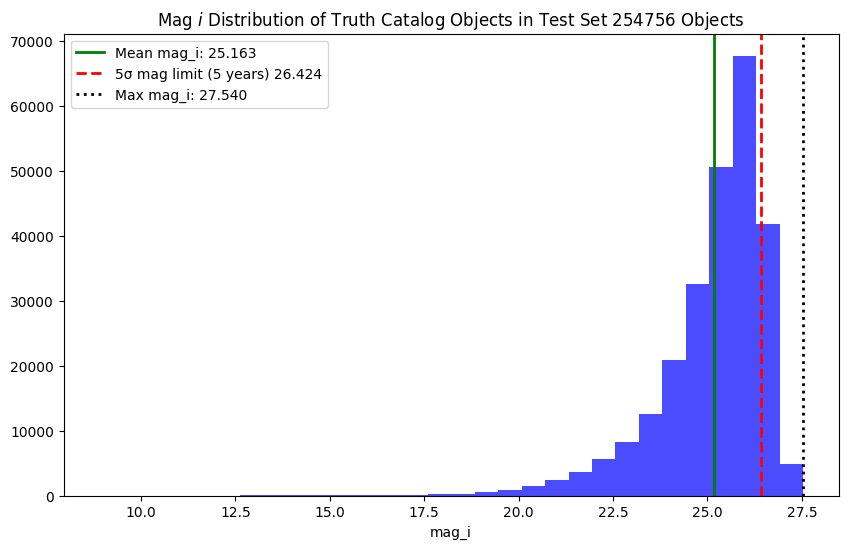

In [132]:
plt.figure(figsize=(10,6))
plt.xlabel('mag_i')
plt.axvline(np.mean(truth_cat_df['mag_i']), color='green', linestyle='solid', linewidth='2', label=f'Mean mag_i: {np.mean(truth_cat_df["mag_i"]):.3f}')
plt.axvline(truth_mag_limit, color='red', linestyle='dashed', linewidth='2', label=f'5σ mag limit (5 years) {truth_mag_limit:.3f}')
plt.axvline(np.max(truth_cat_df['mag_i']), color='black', linestyle='dotted', linewidth='2', label=f'Max mag_i: {np.max(truth_cat_df["mag_i"]):.3f}')
plt.hist(truth_cat_df['mag_i'], bins=30, alpha=0.7, color='blue')
plt.title(f"Mag $i$ Distribution of Truth Catalog Objects in Test Set {len(truth_cat_df)} Objects")
plt.legend()

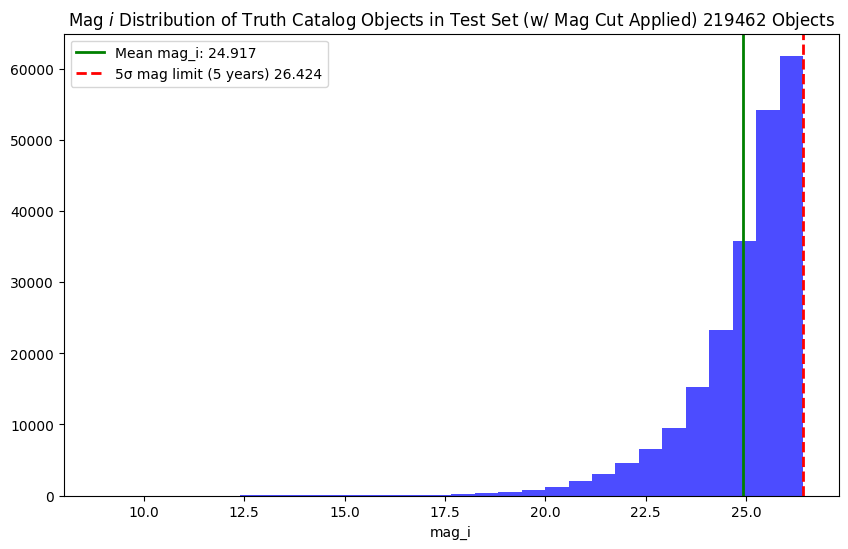

In [133]:
plt.figure(figsize=(10,6))
plt.xlabel('mag_i')
plt.axvline(np.mean(mag_lim_truth_cat['mag_i']), color='green', linestyle='solid', linewidth='2', label=f'Mean mag_i: {np.mean(mag_lim_truth_cat["mag_i"]):.3f}')
plt.axvline(truth_mag_limit, color='red', linestyle='dashed', linewidth='2', label=f'5σ mag limit (5 years) {truth_mag_limit:.3f}')
plt.hist(mag_lim_truth_cat['mag_i'], bins=30, alpha=0.7, color='blue')
plt.title(f"Mag $i$ Distribution of Truth Catalog Objects in Test Set (w/ Mag Cut Applied) {len(mag_lim_truth_cat)} Objects")
plt.legend()

In [130]:
maglim_truth_cat_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_truth_maglim_cat.json'
if not mag_lim_truth_cat.empty:
    mag_lim_truth_cat.to_json(maglim_truth_cat_fn, orient='records')
    print(f"Saved truth catalog (w/ mag cut) of {len(mag_lim_truth_cat)} objects in our test set to {maglim_truth_cat_fn}")

Saved truth catalog (w/ mag cut) of 219462 objects in our test set to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_truth_maglim_cat.json


# Crossmatching Test Detection Catalogs and LSST Test Truth Catalogs

In [139]:
def match_with_truth(det_cat, truth_cat, max_sep=0.5*u.arcsec):
    """
    Match detection catalog with truth catalog with search around sky
    Only keep 1-to-1 matches within max_sep
    """
    if len(det_cat) == 0:
        return pd.DataFrame(), pd.DataFrame()

    det_coords = SkyCoord(ra=det_cat['ra'].values*u.deg, 
                         dec=det_cat['dec'].values*u.deg)
    truth_coords = SkyCoord(ra=truth_cat['ra'].values*u.deg, 
                           dec=truth_cat['dec'].values*u.deg)
    
    idx_det, d2d, _ = det_coords.match_to_catalog_sky(truth_coords)
    good_sep = d2d <= max_sep
    # count how many truth objs match to each det and keep 1-to-1 matches
    unique_truth, truth_counts = np.unique(idx_det[good_sep], return_counts=True)
    good_truth = unique_truth[truth_counts == 1]
    
    final_mask = good_sep & np.isin(idx_det, good_truth)
    matched_det_indices = np.where(final_mask)[0]
    matched_truth_indices = idx_det[final_mask]
    
    matched_det = det_cat.iloc[matched_det_indices].copy()
    matched_truth = truth_cat.iloc[matched_truth_indices].copy()
    
    # match_idx to link matched pairs
    match_idx = np.arange(len(matched_det))
    matched_det['match_idx'] = match_idx
    matched_truth['match_idx'] = match_idx
    print(f"Found {len(matched_det)} matched pairs out of {len(truth_coords)} objs in the test truth catalog")
#     print(final_matches)
    return matched_det, matched_truth

In [ ]:
truth_cat_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_truth_maglim_cat.json'
lsst_truth_cat = pd.read_json(truth_cat_fn, orient='records')
if lsst_truth_cat.empty:
    print("LSST truth catalog for the test set is empty")

## LSST Test Detection Catalog

In [ ]:
det_cat_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_det_cat.json'
lsst_det_cat = pd.read_json(det_cat_fn, orient='records')
if llsst_det_cat.empty:
    print("LSST detection catalog for the test set is empty")    

In [140]:
matched_lsst_det, matched_lsst_truth = match_with_truth(lsst_det_cat, lsst_truth_cat, max_sep=0.5*u.arcsec)

Found 187142 matched pairs out of 219462 objs in the test truth catalog


In [143]:
matched_lsst_det

,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,mag_r_cModel,good,mag_i_cModel,psf_fwhm_u,dec,blendedness,y,parentObjectId,psf_fwhm_z,snr_u_cModel,snr_z_cModel,mag_y_cModel,objectId,snr_r_cModel,psf_fwhm_i,x,mag_g_cModel,mag_z,mag_r,tract,mag_u_cModel,psf_fwhm_g,snr_g_cModel,psf_fwhm_y,ra,mag_i,cutout_x,cutout_y,match_idx
0,True,26.054455,0.839360,"6,2",26.391528,1.372450,7.986091,0.0,25.115672,26.035569,26.685812,True,25.708359,0.925686,-41.222714,0.000000,8301.694152,0,0.847045,4.179386,4.560655,25.650505,14329668756833311,6.237539,0.868881,25067.345009,26.388012,25.141164,26.635976,3258,26.065832,0.906069,8.217093,1.196548,53.668989,25.714607,17.345009,13.694152,0
2,True,23.936885,0.833364,"6,2",26.123854,6.848957,30.585702,1.0,23.963736,26.357919,25.140088,True,24.149873,0.924146,-41.220568,0.000000,8339.863405,0,0.849014,3.377634,11.753589,23.854481,14329668756833406,23.359300,0.867901,25117.101120,26.006479,24.087959,25.257772,3258,26.248074,0.906053,10.749887,1.196572,53.665341,24.252631,67.101120,51.863405,1
3,True,23.860131,0.833865,"6,2",25.951169,8.531146,15.419505,1.0,23.792243,25.744292,25.128124,True,24.548593,0.926936,-41.220301,0.000000,8344.889773,0,0.849001,6.038030,8.587440,23.384706,14329668756833419,16.907972,0.867221,25093.344833,25.346523,24.446765,25.765215,3258,25.124282,0.906057,14.465168,1.196555,53.667098,25.096791,43.344833,56.889773,2
4,True,NaN,0.836197,"6,2",25.781982,-0.727757,6.410049,1.0,26.214673,26.471734,25.731325,True,25.636995,0.926919,-41.220498,0.000000,8341.655391,0,0.846870,2.907301,1.068726,NaN,14329668756833425,11.110027,0.868809,25060.137120,25.441619,26.205720,26.108692,3258,26.072404,0.906063,15.084706,1.195475,53.669548,26.019545,10.137120,53.655391,3
5,True,24.840218,0.836202,"6,2",26.099701,2.856095,5.553817,1.0,25.221534,25.705855,25.710996,True,26.051119,0.926921,-41.219474,0.000000,8359.981043,0,0.848991,6.129022,3.934252,24.807957,14329668756833476,13.713522,0.869373,25071.847099,26.059700,25.306968,25.815141,3258,25.580912,0.907684,10.543681,1.200363,53.668696,26.097443,21.847099,71.981043,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271138,True,24.277057,0.839334,"3,4",25.761952,5.282675,18.336760,1.0,24.342159,25.961592,25.328226,True,24.681961,0.936206,-39.276405,0.000124,16610.399994,15138505587951433,0.890594,4.750308,8.924611,24.222538,15138505587978759,19.369010,0.853307,14475.010613,25.651165,24.487093,25.479414,3442,25.852623,0.911615,15.381087,1.154118,51.394409,24.831444,19.010613,98.399994,187137
271139,True,25.311517,0.839352,"3,4",26.236904,2.033803,3.583680,1.0,NaN,26.627511,26.038974,True,26.476473,0.943142,-39.276079,0.000556,16616.261992,15138505587951433,0.898320,2.798336,NaN,25.250175,15138505587978760,10.246588,0.852219,14491.272984,26.071166,NaN,26.180784,3442,26.448584,0.911627,10.044941,1.154116,51.393242,26.635365,35.272984,104.261993,187138
271140,True,26.986200,0.840082,"3,4",25.347407,0.508712,9.074503,1.0,25.087606,25.443243,25.346740,True,25.387809,0.936179,-39.275945,0.000231,16618.650049,15138505587951461,0.890647,7.870740,4.350674,26.752110,15138505587978822,18.867237,0.854951,14561.001599,25.157279,25.318334,25.489205,3442,25.281788,0.898012,23.210831,1.154086,51.388238,25.576431,105.001599,106.650049,187139
271141,True,26.132345,0.837439,"3,4",26.312939,0.948628,3.461150,1.0,27.125819,26.967916,26.408851,True,26.611819,0.936157,-39.275169,0.011228,16632.612650,15138505587951461,0.893929,1.902155,0.773588,26.133821,15138505587978823,7.871330,0.854956,14555.732485,26.288937,27.171961,26.456067,3442,26.986949,0.898018,9.449028,1.154099,51.388617,26.588257,99.732485,120.612650,187140


In [144]:
matched_lsst_det.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_lsst_det.json', orient='records')
matched_lsst_truth.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_lsst_truth_det.json', orient='records')

## DeepDISC Detection Catalog for Test Set

In [145]:
dd_det_cat_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/pred_s0.45_n0.3.json'
with open(dd_det_cat_fn, 'r') as f:
    dd_det_cat = json.load(f)
dd_det_cat = pd.DataFrame(dd_det_cat)
if dd_det_cat.empty:
    print("DeepDISC detection catalog for the test set is empty")    
dd_det_cat

,id,ra,dec,class,file_name,bbox,score,rle_masks
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.89881134033203, 17.910329818725586, 65.676...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O..."
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.83981704711914, 122.48597717285156, 64.390...",0.996112,"{'size': [150, 147], 'counts': 'hk64`45L2N101N..."
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9978141784668, 41.76107406616211, 77.09436...",0.994498,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10..."
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.68435668945312, 133.7820587158203, 115.389...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O..."
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.06954193115234, 100.67486572265625, 104.23...",0.988882,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N..."
...,...,...,...,...,...,...,...,...
237876,237876,51.387144,-39.274313,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[113.27100372314453, 129.22518920898438, 127.2...",0.630430,"{'size': [144, 147], 'counts': 'Zg`01Z45000MhK..."
237877,237877,51.385543,-39.274108,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[138.3282470703125, 135.40371704101562, 146.81...",0.527989,"{'size': [144, 147], 'counts': 'mWd02]42OO2NdK'}"
237878,237878,51.391806,-39.275579,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[46.38136291503906, 104.44239807128906, 64.198...",0.489888,"{'size': [144, 147], 'counts': 'oX76Y41O2O0000..."
237879,237879,51.390402,-39.280363,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[67.48326873779297, 19.856773376464844, 82.159...",0.458763,"{'size': [144, 147], 'counts': 'hT:6Z41O0000O2..."


In [ ]:
matched_dd_det, matched_dd_lsst_truth = match_with_truth(dd_det_cat, lsst_truth_cat, max_sep=0.5*u.arcsec)

Found 168846 matched pairs out of 219462 objs in the test truth catalog


In [147]:
matched_dd_det

,id,ra,dec,class,file_name,bbox,score,rle_masks,match_idx
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.89881134033203, 17.910329818725586, 65.676...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O...",0
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.83981704711914, 122.48597717285156, 64.390...",0.996112,"{'size': [150, 147], 'counts': 'hk64`45L2N101N...",1
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9978141784668, 41.76107406616211, 77.09436...",0.994498,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10...",2
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.68435668945312, 133.7820587158203, 115.389...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O...",3
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.06954193115234, 100.67486572265625, 104.23...",0.988882,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N...",4
...,...,...,...,...,...,...,...,...,...
237869,237869,51.394727,-39.274172,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[7.8242106437683105, 133.2135467529297, 21.378...",0.866914,"{'size': [144, 147], 'counts': '[j13\42N11O0O3...",168841
237870,237870,51.389894,-39.277004,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[74.79135131835938, 80.49608612060547, 89.0455...",0.831558,"{'size': [144, 147], 'counts': 'XV;1]43O1N1001...",168842
237871,237871,51.393331,-39.278969,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[27.51228141784668, 45.7242317199707, 40.52602...",0.793506,"{'size': [144, 147], 'counts': 'ca44[4100001O]...",168843
237873,237873,51.393632,-39.279651,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[23.278766632080078, 33.430564880371094, 36.36...",0.688119,"{'size': [144, 147], 'counts': 'Wo33\42O00O3Mi...",168844


In [148]:
matched_dd_det.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_dd_det.json', orient='records')
matched_dd_lsst_truth.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/matched_lsst_truth_dd.json', orient='records')